## Deep Convolutional Generative Adversarial Neural Network (DCGAN)

importing modules and mnist handwriting dataset from keras (Execute the Cells Sequentially)

In [0]:
import numpy as np
from keras.datasets import mnist
import imageio
import re
import glob
import shutil
import os
import matplotlib.pyplot as plt
import math
from tqdm import tqdm,tqdm_notebook,trange
import keras.backend as K
from IPython import display
from keras.models import Sequential,Model
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Dense,Convolution2D,BatchNormalization,Conv2DTranspose,MaxPooling2D,Activation,Flatten,Reshape,Input,Dropout
from keras.optimizers import Adam

Using TensorFlow backend.


Reshaping Data to add Color Channel and Rescaling from [0-255] => [0-1]

In [0]:
(X_train,Y_train),(X_test,Y_test)=mnist.load_data()
X_train=X_train.reshape(X_train.shape[:]+tuple([1]))
X_test=X_test.reshape(X_test.shape[:]+tuple([1]))
X_train=X_train.astype("float32")
X_test=X_test.astype("float32")
#X_train=np.concatenate((X_train,X_test),axis=0)
X_train-=127.5
X_train/=127.5

In [0]:
print(X_train.shape)
print(Y_train.shape)

(60000, 28, 28, 1)
(60000,)


Building Generator

In [0]:
G=Sequential([Dense(7*7*128,input_shape=[100]),
              BatchNormalization(),
              LeakyReLU(0.2),
              Reshape((7,7,128)),
              Conv2DTranspose(64,5,strides=(2,2),padding="same"),
              BatchNormalization(),
              LeakyReLU(0.2),
              Conv2DTranspose(1,5,strides=(2,2),padding="same"),
              Flatten(),
              Activation("tanh")
              
])

In [0]:
G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
batch_normalization_1 (Batch (None, 6272)              25088     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
__________

Building Discriminator

In [0]:
D=Sequential([Reshape(input_shape=[28*28*1],target_shape=(28,28,1)),
        Convolution2D(64,5,strides=(1,1),input_shape=[28,28,1],padding="same"),
        LeakyReLU(),
        Dropout(0.2),
        Convolution2D(128,5,strides=(1,1),padding="same"),
        LeakyReLU(),
        Dropout(0.2),
        Flatten(),
        LeakyReLU(),
        Dropout(0.2),
        Dense(1),
        Activation('sigmoid')
    ])

In [0]:
D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 28, 28, 128)       0         
__________

In [0]:
D.compile(loss="binary_crossentropy",optimizer=Adam(lr=0.001))

In [0]:


D.trainable=False
I=Input(shape=[100])
g=G(I)
d=D(g)
adv=Model(inputs=[I],outputs=[d])

In [0]:
adv.summary()
adv.compile(loss="binary_crossentropy",optimizer=Adam(lr=0.001))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               865281    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 306945    
Total params: 1,172,226
Trainable params: 852,609
Non-trainable params: 319,617
_________________________________________________________________


In [0]:
# Load The Trained Weights
#D.load_weights("Weights/disc.h5")
#adv.load_weights("Weights/adv.h5")

In [0]:
# Removing Frames Directory and restarting the process of Saving Frames
try:
    shutil.rmtree("frames")
except FileNotFoundError:
    pass
os.mkdir("frames")
os.chdir("frames")

Training Started

In [0]:

epoch=1 # Increase the epoch count to ~10. I can't wait to see the results so reducing it to 1 
        #:3
batch_size=128
X=0
ganLoss=[]
discLoss=[]
X_train=X_train
writer=imageio.get_writer("dcgan.gif",mode="I")
for i in range(epoch):
    print("Epoch #{}: \n\n".format(i+1),end=" ")
    bar=range(0,X_train.shape[0])
    for j in tqdm(bar):
        noise=np.random.rand(batch_size,100)
        real=X_train[np.random.randint(0,X_train.shape[0],size=batch_size)].reshape(-1,28*28*1)
        pred=G.predict(noise,batch_size=batch_size)
        inp=np.concatenate((pred,real))
        op=np.array([0]*batch_size+[0.9]*batch_size)
        #print(op[0].shape)
        D.trainable=True
        dLoss=D.train_on_batch(inp,op)
        discLoss.append(dLoss)
        #print("\n\n\n\nDisc Training")
        #print("Adv Non: ",np.sum([K.count_params(p) for p in set(adv.non_trainable_weights)]))
        #print("Disc Non: ",np.sum([K.count_params(p) for p in set(D.non_trainable_weights)]))
        op=np.array([1]*batch_size)
        D.trainable=False
        noise=np.random.rand(batch_size,100)
        gLoss=adv.train_on_batch(noise,op)
        ganLoss.append(gLoss)
        if not j%1000:
          plt.figure(figsize=(4,4))
          p=G.predict(np.random.rand(16,100),batch_size=16)*127.5+127.5
          for i in range(p.shape[0]):
              plt.subplot(4,4,i+1)
              plt.imshow(p[i].reshape(28,28),interpolation="nearest")
              plt.axis('off')
          plt.savefig("frame.png".format(X))
          plt.close()
          writer.append_data(imageio.imread("frame.png".format(X)))
          os.remove("frame.png")
        X+=1
        #print("\n\n\n\nGAN training")
        #print("Adv Non: ",np.sum([K.count_params(p) for p in set(adv.non_trainable_weights)]))
        #print("Disc Non: ",np.sum([K.count_params(p) for p in set(D.non_trainable_weights)]))
        if not j%1000:
          print("\nGen Loss: {}\t Disc Loss: {}".format(gLoss,dLoss))
writer.close()

  0%|          | 0/60000 [00:00<?, ?it/s]

Epoch #1: 

 

  0%|          | 1/60000 [00:05<90:15:47,  5.42s/it]


Gen Loss: 0.37151411175727844	 Disc Loss: 0.715788722038269


  2%|▏         | 1001/60000 [03:49<3:44:59,  4.37it/s]


Gen Loss: 1.6388263702392578	 Disc Loss: 0.29192686080932617


  3%|▎         | 2001/60000 [07:32<3:38:25,  4.43it/s]


Gen Loss: 1.6839313507080078	 Disc Loss: 0.3363759517669678


  5%|▌         | 3001/60000 [11:15<3:33:43,  4.45it/s]


Gen Loss: 1.5488502979278564	 Disc Loss: 0.2596348524093628


  7%|▋         | 4001/60000 [14:57<3:29:28,  4.46it/s]


Gen Loss: 2.1327943801879883	 Disc Loss: 0.34553349018096924


  8%|▊         | 5001/60000 [18:40<3:25:24,  4.46it/s]


Gen Loss: 2.718737840652466	 Disc Loss: 0.38252872228622437


 10%|█         | 6001/60000 [22:23<3:21:26,  4.47it/s]


Gen Loss: 2.7174549102783203	 Disc Loss: 0.35136497020721436


 12%|█▏        | 7001/60000 [26:05<3:17:31,  4.47it/s]


Gen Loss: 2.7673141956329346	 Disc Loss: 0.389104962348938


 13%|█▎        | 8001/60000 [29:47<3:13:38,  4.48it/s]


Gen Loss: 2.5257315635681152	 Disc Loss: 0.39083540439605713


 15%|█▌        | 9001/60000 [33:29<3:09:48,  4.48it/s]


Gen Loss: 2.3903660774230957	 Disc Loss: 0.3862731456756592


 17%|█▋        | 10001/60000 [37:12<3:05:58,  4.48it/s]


Gen Loss: 2.4294419288635254	 Disc Loss: 0.3815060257911682


 18%|█▊        | 11001/60000 [40:54<3:02:10,  4.48it/s]


Gen Loss: 2.7564697265625	 Disc Loss: 0.35310354828834534


 20%|██        | 12001/60000 [44:36<2:58:23,  4.48it/s]


Gen Loss: 2.934518337249756	 Disc Loss: 0.36837825179100037


 22%|██▏       | 13001/60000 [48:18<2:54:38,  4.49it/s]


Gen Loss: 2.858599901199341	 Disc Loss: 0.3523154854774475


 23%|██▎       | 14001/60000 [52:01<2:50:54,  4.49it/s]


Gen Loss: 2.8479366302490234	 Disc Loss: 0.3616192042827606


 25%|██▌       | 15001/60000 [55:44<2:47:11,  4.49it/s]


Gen Loss: 1.8278580904006958	 Disc Loss: 0.39071184396743774


 27%|██▋       | 16001/60000 [59:26<2:43:26,  4.49it/s]


Gen Loss: 1.3498765230178833	 Disc Loss: 0.4090532958507538


 28%|██▊       | 17001/60000 [1:03:08<2:39:42,  4.49it/s]


Gen Loss: 2.4239232540130615	 Disc Loss: 0.3783375918865204


 30%|███       | 18001/60000 [1:06:50<2:35:57,  4.49it/s]


Gen Loss: 2.531902313232422	 Disc Loss: 0.3585505485534668


 32%|███▏      | 19001/60000 [1:10:32<2:32:13,  4.49it/s]


Gen Loss: 3.019815444946289	 Disc Loss: 0.43563777208328247


 33%|███▎      | 20001/60000 [1:14:15<2:28:29,  4.49it/s]


Gen Loss: 2.3157029151916504	 Disc Loss: 0.42601528763771057


 35%|███▌      | 21001/60000 [1:17:57<2:24:46,  4.49it/s]


Gen Loss: 2.1536529064178467	 Disc Loss: 0.4098860025405884


 37%|███▋      | 22001/60000 [1:21:40<2:21:04,  4.49it/s]


Gen Loss: 2.498408317565918	 Disc Loss: 0.34474262595176697


 38%|███▊      | 23001/60000 [1:25:23<2:17:20,  4.49it/s]


Gen Loss: 2.2927937507629395	 Disc Loss: 0.40344780683517456


 40%|████      | 24001/60000 [1:29:04<2:13:36,  4.49it/s]


Gen Loss: 2.010256767272949	 Disc Loss: 0.3590259850025177


 42%|████▏     | 25001/60000 [1:32:46<2:09:52,  4.49it/s]


Gen Loss: 2.5151898860931396	 Disc Loss: 0.37675440311431885


 43%|████▎     | 26001/60000 [1:36:27<2:06:08,  4.49it/s]


Gen Loss: 2.1890311241149902	 Disc Loss: 0.39507272839546204


 45%|████▌     | 27001/60000 [1:40:09<2:02:24,  4.49it/s]


Gen Loss: 2.140129566192627	 Disc Loss: 0.3792586922645569


 47%|████▋     | 28001/60000 [1:43:50<1:58:40,  4.49it/s]


Gen Loss: 2.22930645942688	 Disc Loss: 0.4018510580062866


 48%|████▊     | 29001/60000 [1:47:32<1:54:56,  4.49it/s]


Gen Loss: 2.1769912242889404	 Disc Loss: 0.3658837080001831


 50%|█████     | 30001/60000 [1:51:13<1:51:13,  4.50it/s]


Gen Loss: 2.6480917930603027	 Disc Loss: 0.38276904821395874


 52%|█████▏    | 31001/60000 [1:54:55<1:47:30,  4.50it/s]


Gen Loss: 2.388747453689575	 Disc Loss: 0.37974923849105835


 53%|█████▎    | 32001/60000 [1:58:36<1:43:46,  4.50it/s]


Gen Loss: 2.1271090507507324	 Disc Loss: 0.39873403310775757


 55%|█████▌    | 33001/60000 [2:02:18<1:40:03,  4.50it/s]


Gen Loss: 2.276254177093506	 Disc Loss: 0.401680588722229


 57%|█████▋    | 34001/60000 [2:05:59<1:36:20,  4.50it/s]


Gen Loss: 2.61434268951416	 Disc Loss: 0.3725355565547943


 58%|█████▊    | 35001/60000 [2:09:40<1:32:37,  4.50it/s]


Gen Loss: 2.1911230087280273	 Disc Loss: 0.39105358719825745


 60%|██████    | 36001/60000 [2:13:21<1:28:54,  4.50it/s]


Gen Loss: 2.387612819671631	 Disc Loss: 0.370792955160141


 62%|██████▏   | 37001/60000 [2:17:02<1:25:11,  4.50it/s]


Gen Loss: 2.772088050842285	 Disc Loss: 0.4074253439903259


 63%|██████▎   | 38001/60000 [2:20:44<1:21:28,  4.50it/s]


Gen Loss: 2.609544277191162	 Disc Loss: 0.3804730772972107


 65%|██████▌   | 39001/60000 [2:24:25<1:17:45,  4.50it/s]


Gen Loss: 2.493788719177246	 Disc Loss: 0.3860812783241272


 67%|██████▋   | 40001/60000 [2:28:06<1:14:02,  4.50it/s]


Gen Loss: 2.0292255878448486	 Disc Loss: 0.3999963104724884


 68%|██████▊   | 41001/60000 [2:31:47<1:10:20,  4.50it/s]


Gen Loss: 2.4064598083496094	 Disc Loss: 0.4631681740283966


 70%|███████   | 42001/60000 [2:35:29<1:06:38,  4.50it/s]


Gen Loss: 2.4346795082092285	 Disc Loss: 0.38191723823547363


 72%|███████▏  | 43001/60000 [2:39:11<1:02:55,  4.50it/s]


Gen Loss: 2.417961359024048	 Disc Loss: 0.39999061822891235


 73%|███████▎  | 44001/60000 [2:42:52<59:13,  4.50it/s]


Gen Loss: 3.0443239212036133	 Disc Loss: 0.38704031705856323


 75%|███████▌  | 45001/60000 [2:46:33<55:30,  4.50it/s]


Gen Loss: 2.965195894241333	 Disc Loss: 0.3860161304473877


 77%|███████▋  | 46001/60000 [2:50:15<51:48,  4.50it/s]


Gen Loss: 2.6411571502685547	 Disc Loss: 0.41860952973365784


 78%|███████▊  | 47001/60000 [2:53:57<48:06,  4.50it/s]


Gen Loss: 2.634511709213257	 Disc Loss: 0.3672422766685486


 80%|████████  | 48001/60000 [2:57:39<44:24,  4.50it/s]


Gen Loss: 2.3664941787719727	 Disc Loss: 0.3819659948348999


 82%|████████▏ | 49001/60000 [3:01:22<40:42,  4.50it/s]


Gen Loss: 2.3702468872070312	 Disc Loss: 0.33435893058776855


 83%|████████▎ | 50001/60000 [3:05:04<37:00,  4.50it/s]


Gen Loss: 2.4401395320892334	 Disc Loss: 0.39222002029418945


 85%|████████▌ | 51001/60000 [3:08:46<33:18,  4.50it/s]


Gen Loss: 1.9715114831924438	 Disc Loss: 0.452778697013855


 87%|████████▋ | 52001/60000 [3:12:28<29:36,  4.50it/s]


Gen Loss: 2.733853340148926	 Disc Loss: 0.3814883530139923


 88%|████████▊ | 53001/60000 [3:16:10<25:54,  4.50it/s]


Gen Loss: 1.6963716745376587	 Disc Loss: 0.36711370944976807


 90%|█████████ | 54001/60000 [3:19:53<22:12,  4.50it/s]


Gen Loss: 1.7176015377044678	 Disc Loss: 0.41060298681259155


 92%|█████████▏| 55001/60000 [3:23:35<18:30,  4.50it/s]


Gen Loss: 1.979215145111084	 Disc Loss: 0.3817042112350464


 93%|█████████▎| 56001/60000 [3:27:18<14:48,  4.50it/s]


Gen Loss: 1.88180673122406	 Disc Loss: 0.38290995359420776


 95%|█████████▌| 57001/60000 [3:31:00<11:06,  4.50it/s]


Gen Loss: 1.9867639541625977	 Disc Loss: 0.38696593046188354


 97%|█████████▋| 58001/60000 [3:34:42<07:23,  4.50it/s]


Gen Loss: 2.654177665710449	 Disc Loss: 0.38147470355033875


 98%|█████████▊| 59001/60000 [3:38:24<03:41,  4.50it/s]


Gen Loss: 2.2255101203918457	 Disc Loss: 0.39726901054382324


100%|██████████| 60000/60000 [3:42:05<00:00,  4.50it/s]


In [0]:
os.mkdir("../Weights")
shutil.copy2("dcgan.gif","dcgan.gif.png")

In [0]:
D.save_weights("../Weights/disc.h5")
adv.save_weights("../Weights/adv.h5")

(-0.5, 27.5, 27.5, -0.5)

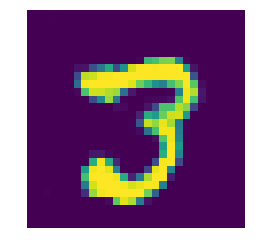

In [0]:
plt.figure(figsize=(4,4))
plt.imshow(G.predict(np.random.rand(1,100)).reshape(28,28)*127.5+127.5,interpolation="nearest")
plt.axis('off')

## Training Animation

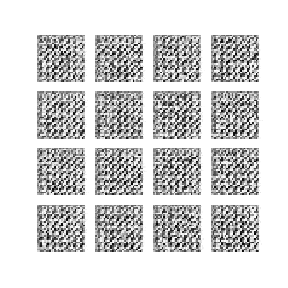

In [0]:
#os.chdir("frames")
display.Image(filename="dcgan.gif.png")